# Heart Attack Prediction
Binary classification task of prediction of Heart Attack Risk. The labels indicate 1 = high risk and 0 = low risk.

## This notebook
Featuring:
- **Sklearn Pipelines**
- **Permutation importance**
- **Hyperparameter optimization (Optuna)**
- **Final model explicability using SHAP values**

### Description
The notebook starts by briefly exploring the data and testing different models with different preprocessing techniques. The best architecture is then used to run a *permutation importance analysis* to assess the features' importances. The new classification pipeline is optimized using *Optuna*, retrained using the whole data and finally we analyse the model's predictions according to the input features' values using *SHAP values*. 

### Data location
The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/data)

# Main imports

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

# Numerical preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For creating pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Data splitting and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate

# Performance metrics
from sklearn.metrics import classification_report, accuracy_score

# Reading the data

In [2]:
df = pd.read_csv("heart.csv")
print(df.shape)
df.head()

(303, 14)


age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

## Checking for duplicates

In [3]:
print(df.shape)
df.drop_duplicates(keep="first",inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(303, 14)
(302, 14)


## Checking for missing values

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# Feature engineering

In [5]:
# Age categories
df["age_group"] = pd.cut(df["age"], 
                         bins=[0, 30, 50, 70, np.inf],
                         labels=[0, 1, 2, 3]) # labels=["young", "middle-aged", "senior", "elderly"]

# Blood pressure categories
df["bp_category"] = pd.cut(df["trtbps"], 
                           bins=[0, 90, 120, 140, 200],
                           labels=[0, 1, 2, 3]) # labels=["low", "normal", "pre-high", "high"]

# Cholesterol to age ratio
df["chol_age_ratio"] = df["chol"] / df["age"]

# Cholesterol to resting blood pressure
df["chol_trtbps_ratio"] = df["chol"] / df["trtbps"]

# Chess pain and thallium stress association
df["cp_thall"] = df["cp"] * df["thall"]

# Age and resting blood pressure association
df["age_trtbps"] = df["age"] * df["trtbps"]

In [6]:
# Cholesterol ranges
# Ref.: https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean
df["chol_range"] = pd.cut(df["chol"], 
                          bins=[0, 200, 240, np.inf], 
                          right=False, 
                          labels=[0, 1, 2]) # ["healthy", "at risk", "dangerous"]

In [7]:
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  ...  \
0   63    1   3     145   233    1        0       150     0      2.3  ...   
1   37    1   2     130   250    0        1       187     0      3.5  ...   
2   41    0   1     130   204    0        0       172     0      1.4  ...   
3   56    1   1     120   236    0        1       178     0      0.8  ...   
4   57    0   0     120   354    0        1       163     1      0.6  ...   

   caa  thall  output  age_group bp_category chol_age_ratio  \
0    0      1       1          2           3       3.698413   
1    0      2       1          1           2       6.756757   
2    0      2       1          1           2       4.975610   
3    0      2       1          2           1       4.214286   
4    0      2       1          2           1       6.210526   

   chol_trtbps_ratio  cp_thall  age_trtbps  chol_range  
0           1.606897         3        9135           1  
1           1.923077         4        4810           2  
2           1.569231         2        5330           1  
3           1.966667         2        6720           1  
4           2.950000         0        6840           2  

[5 rows x 21 columns]

In [8]:
numerical_features = ["age", "trtbps", "chol", "thalachh", "oldpeak", "caa", "chol_age_ratio", "chol_trtbps_ratio", "cp_thall", "age_trtbps"]
nominal_features = ["sex", "fbs", "exng"]
ordinal_features = ["cp", "restecg", "slp", "thall", "age_group", "bp_category", "chol_range"]
target = "output"

# Exploratory analysis

## Numerical features

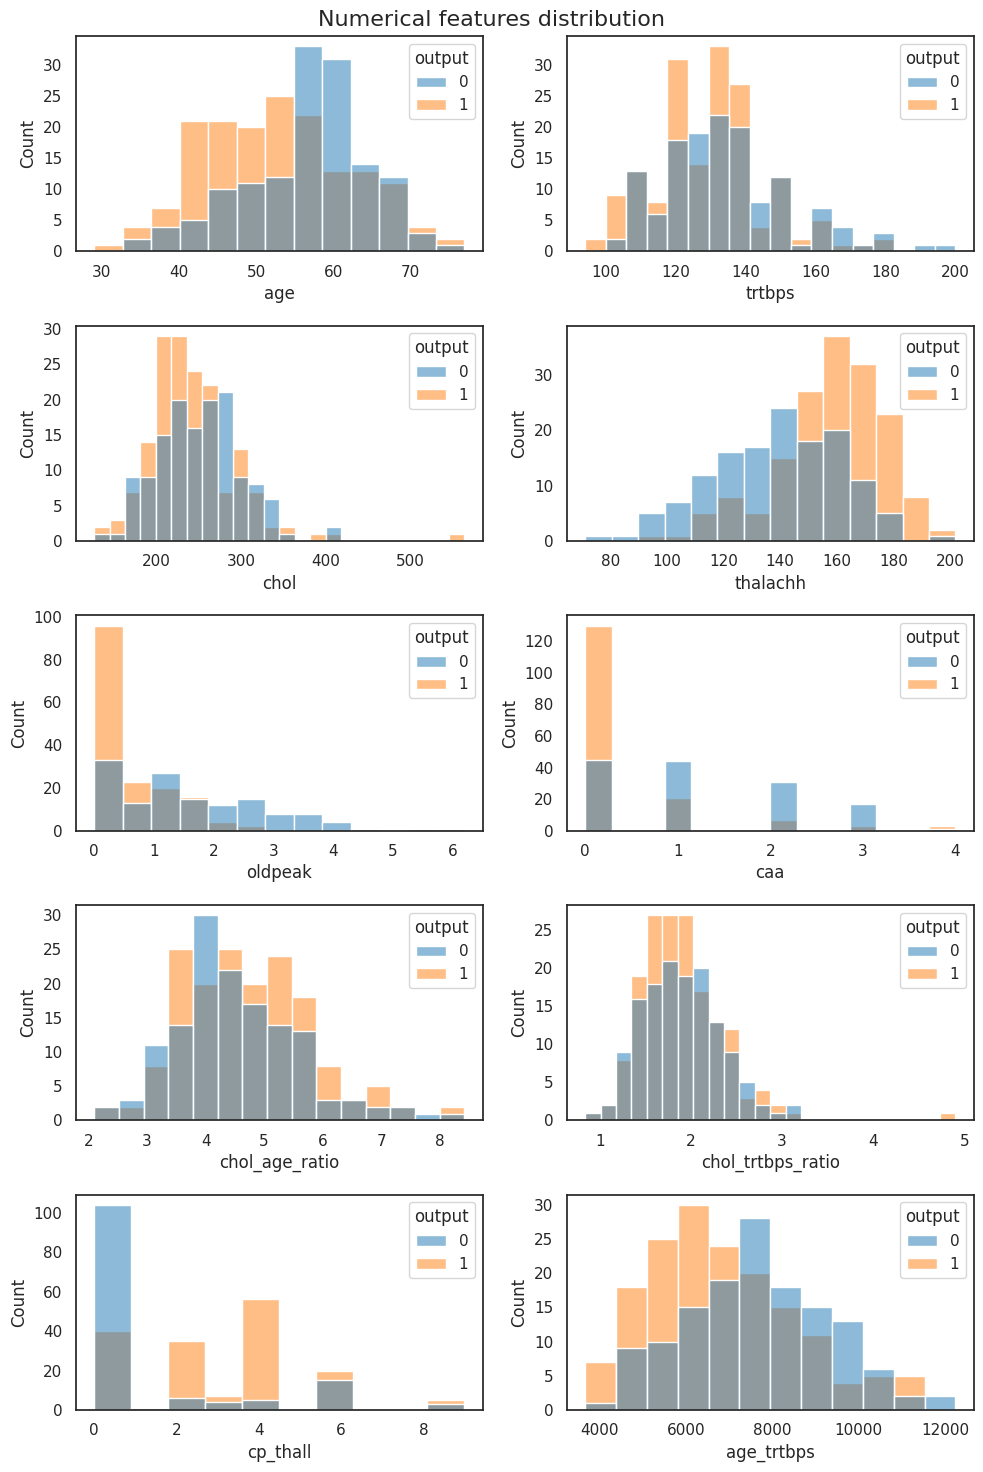

In [9]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.histplot(df, x=feat, hue="output", ax=ax, stat="count")
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

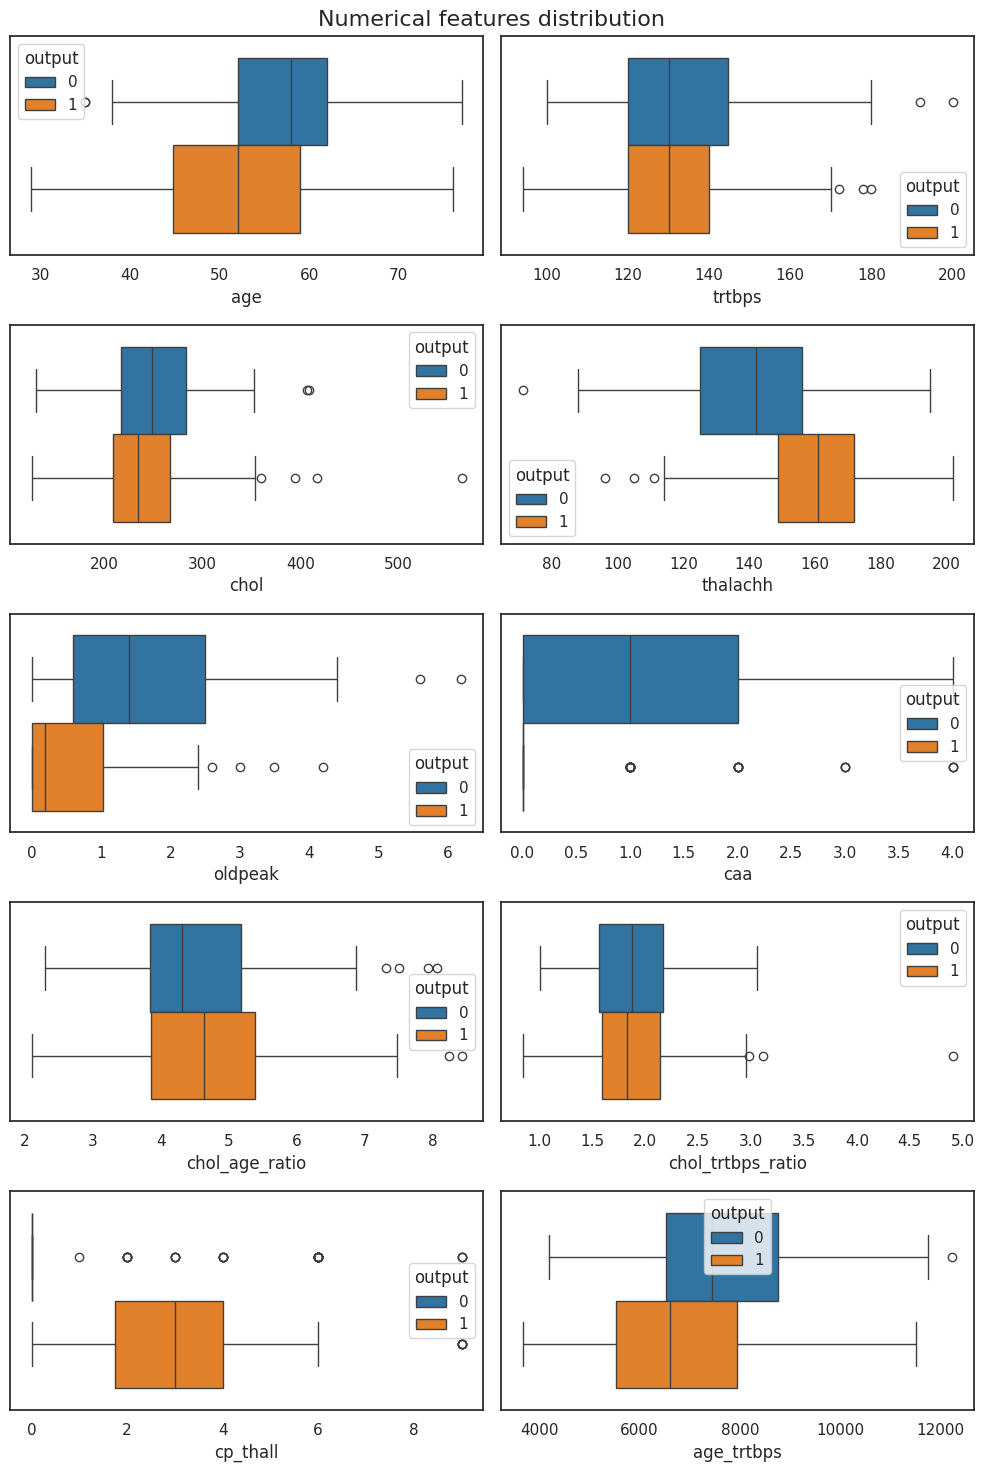

In [10]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(df, x=feat, hue="output", ax=ax)
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

### Outliers analysis
- `caa`: Looks like there are patients with risk of heart attack with more major blood vessels (caa). I think those are outliers since most of the unhealthy people have tops 1 major blood vessel.
- `chol_trtbps_ratio`: Looks like there's a patient with a really high cholesterol and/or low blood pressure. Might be an outlier.

In [11]:
df.loc[df["output"] == 1, "caa"].value_counts()

caa
0    130
1     21
2      7
3      3
4      3
Name: count, dtype: int64

In [12]:
print(df.shape)
df = df.loc[~((df["output"] == 1) & (df["caa"] > 1))].copy(deep=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(302, 21)
(289, 21)


In [13]:
print(df.shape)
df = df.loc[df["chol_trtbps_ratio"] < 4].copy(deep=True)
print(df.shape)

(289, 21)
(288, 21)


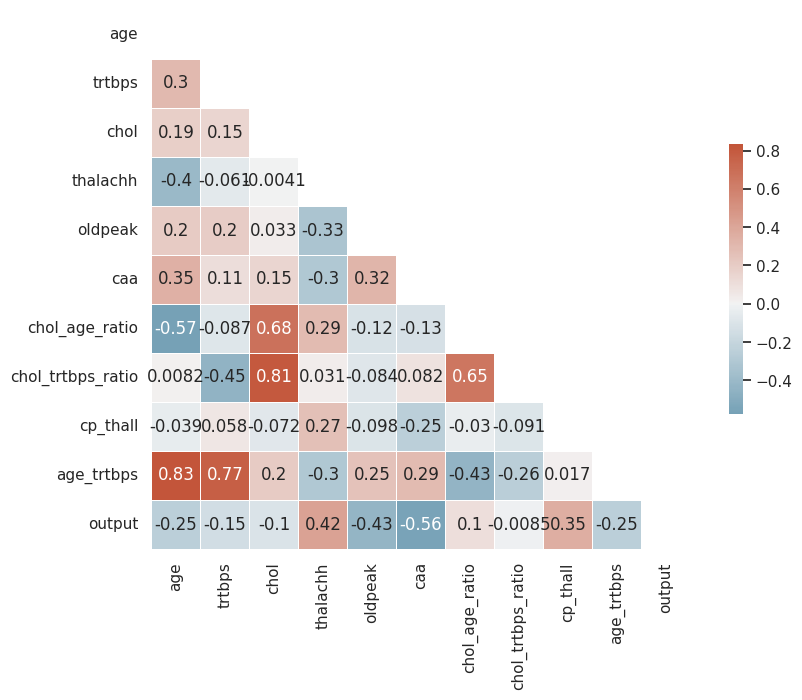

In [14]:
corr = df[numerical_features + ["output"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [15]:
# Dropping highly correlated features
drop_features = ["age_trtbps", "chol_trtbps_ratio"]
numerical_features = [feat for feat in numerical_features if feat not in drop_features]
df.drop(columns=drop_features, inplace=True, errors="ignore")
df.shape

(288, 19)

## Categorical features

### Nominal

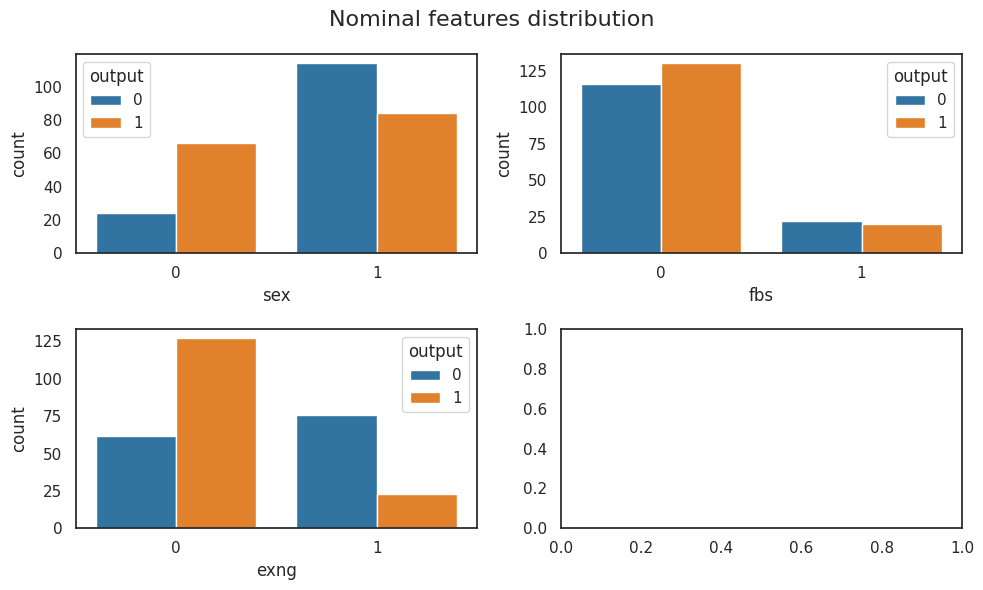

In [16]:
ncols = 2
nrows = int(np.ceil(len(nominal_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(nominal_features, axes.flatten()):
    sns.countplot(df, x=feat, hue="output", ax=ax, stat="count")

fig.suptitle("Nominal features distribution", fontsize=16)
fig.tight_layout()
plt.show()

### Ordinal

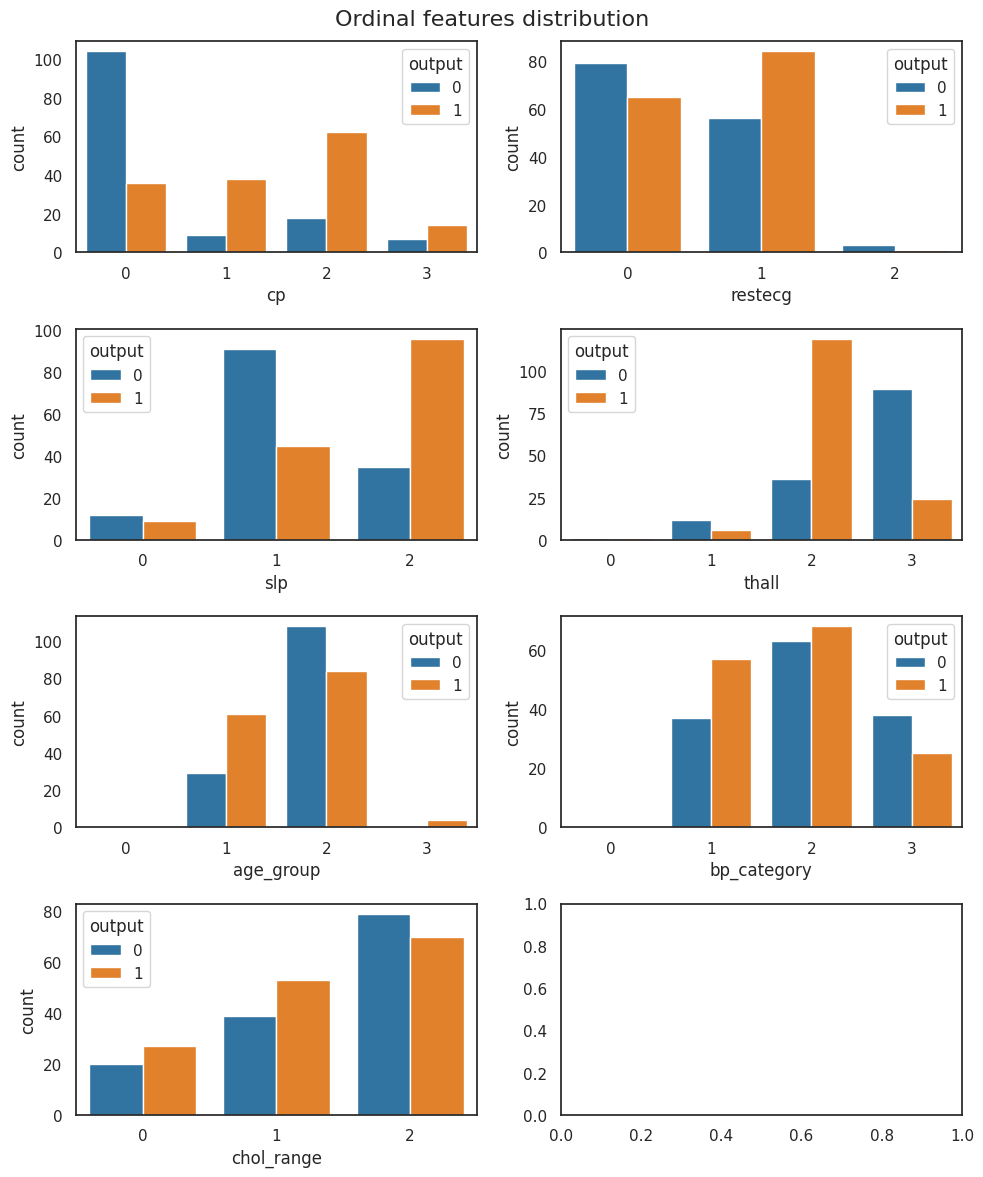

In [17]:
ncols = 2
nrows = int(np.ceil(len(ordinal_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(ordinal_features, axes.flatten()):
    sns.countplot(df, x=feat, hue="output", ax=ax, stat="count")

fig.suptitle("Ordinal features distribution", fontsize=16)
fig.tight_layout()
plt.show()

`age_group`: Interestingly the age_group 1 which is ages between 30 and 50 are more likely to have heart problems.

## age_group vs numerical features

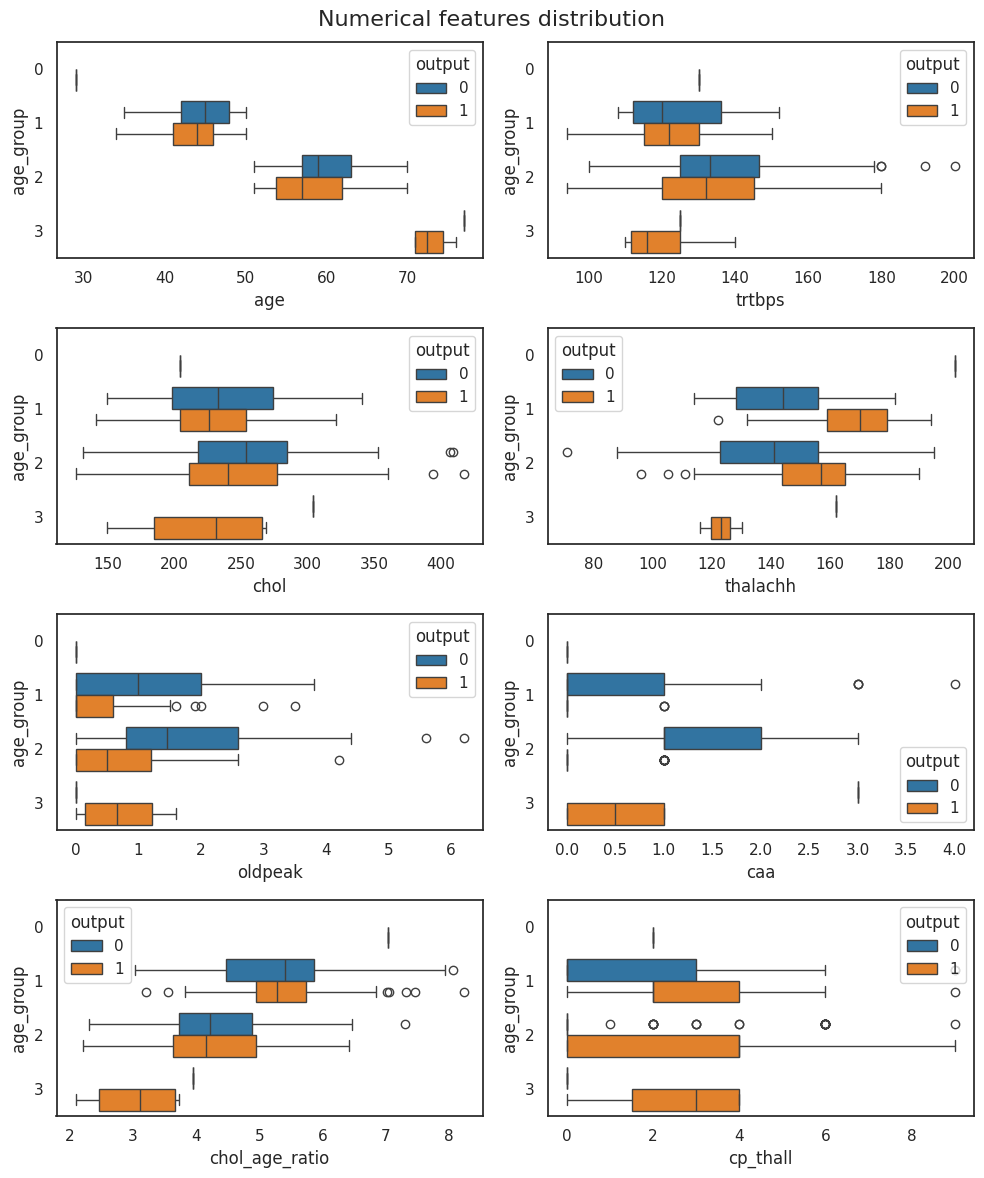

In [18]:
ncols = 2
nrows = int(np.ceil(len(numerical_features) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*3))
for feat, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(df, x=feat, y="age_group", hue="output", ax=ax)
fig.suptitle("Numerical features distribution", fontsize=16)
fig.tight_layout()
plt.show()

# Splitting into train and test datasets

In [19]:
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=df["output"].values)

# Preprocessing pipeline

In [20]:
categorical_features = nominal_features + ordinal_features
print(f"Numerical features: {numerical_features}")
print(f"Nominal features: {nominal_features}")
print(f"Ordinal features: {ordinal_features}")

Numerical features: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa', 'chol_age_ratio', 'cp_thall']
Nominal features: ['sex', 'fbs', 'exng']
Ordinal features: ['cp', 'restecg', 'slp', 'thall', 'age_group', 'bp_category', 'chol_range']


In [21]:
from typing import Optional, List, Union
from sklearn.base import BaseEstimator, TransformerMixin


class PreprocessPipeline(BaseEstimator, TransformerMixin):
    """
    Preprocessing pipeline for the numeric input
    """
    def __init__(self,
                 columns: List[str], 
                 transformer: Union[BaseEstimator, str]="passthrough"):
        self.columns = columns
        if isinstance(transformer, BaseEstimator) or\
            transformer.strip().lower() in ["passthrough", "drop"]:
            self.transformer = transformer
        else:
            raise ValueError("'transformer' must be an instance of `BaseEstimator` or one of ['passthrough', 'drop'].")
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if hasattr(X, "columns") else list[range(len(X.shape[1]))]
        if isinstance(self.transformer, BaseEstimator):
            # Fit the transformer
            self.transformer.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None):
        if self.transformer == "passthrough":
            return X[self.columns]
        elif self.transformer == "drop":
            # Return an empty array
            return np.empty(shape=(len(X), 0))
        X_transform = self.transformer.transform(X[self.columns])
        return X_transform

    def get_feature_names_out(self, input_features=None):
        """
        Returns the names of the features after transformation.
        """
        if isinstance(self.transformer, BaseEstimator):
            # If transformer changes feature names
            if hasattr(self.transformer, "get_feature_names_out"):
                return self.transformer.get_feature_names_out(self.columns)
        # Otherwise, return the original column names
        return self.columns

# Full classification pipeline

In [22]:
from sklearn.dummy import DummyClassifier


clf_pipe = Pipeline([
    ("features", FeatureUnion([
        ("numerical", PreprocessPipeline(numerical_features)),
        ("categorical-nominal", PreprocessPipeline(nominal_features)),
        ("categorical-ordinal", PreprocessPipeline(ordinal_features))
    ])),
    ("clf", DummyClassifier())
])
clf_pipe

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numerical',
                                                 PreprocessPipeline(columns=['age',
                                                                             'trtbps',
                                                                             'chol',
                                                                             'thalachh',
                                                                             'oldpeak',
                                                                             'caa',
                                                                             'chol_age_ratio',
                                                                             'cp_thall'])),
                                                ('categorical-nominal',
                                                 PreprocessPipeline(columns=['sex',
                                                                             'fbs',
                                                                             'exng'])),
                                                ('categorical-ordinal',
                                                 PreprocessPipeline(columns=['cp',
                                                                             'restecg',
                                                                             'slp',
                                                                             'thall',
                                                                             'age_group',
                                                                             'bp_category',
                                                                             'chol_range']))])),
                ('clf', DummyClassifier())])

# Best model selection

In [23]:
# Preprocessing
from sklearn.preprocessing import TargetEncoder, PowerTransformer, QuantileTransformer, RobustScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Grid for testing all combinations
param_grid = {
    "features__numerical__transformer": ["passthrough",
                                    "drop",
                                    MinMaxScaler(), 
                                    StandardScaler(),
                                    PowerTransformer(), 
                                    QuantileTransformer(n_quantiles=100, random_state=42),
                                    RobustScaler()],
    "features__categorical-nominal__transformer": [OneHotEncoder(handle_unknown="ignore"),
                                                   TargetEncoder(random_state=42)],
    "features__categorical-ordinal__transformer": ["passthrough", "drop", StandardScaler()],
    
    "clf": [LogisticRegression(random_state=42, max_iter=1000),
            RidgeClassifier(random_state=42),
            LinearSVC(random_state=42),
            SVC(random_state=42),
            KNeighborsClassifier(), 
            GradientBoostingClassifier(random_state=42),
            Perceptron(random_state=42),
            PassiveAggressiveClassifier(random_state=42),
            DecisionTreeClassifier(random_state=42),
            RandomForestClassifier(random_state=42),
            AdaBoostClassifier(random_state=42, 
                               algorithm="SAMME"),
            BaggingClassifier(random_state=42),
            ExtraTreesClassifier(random_state=42),
            XGBClassifier(random_state=42,
                          n_estimators=200),
            LGBMClassifier(random_state=42,
                           verbose=-1, 
                           n_estimators=200),
            CatBoostClassifier(random_state=42, 
                               silent=True,
                               iterations=600)]
}

In [24]:
%%time
# Disabling sklearn's forced warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import GridSearchCV, StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf_pipe,
                           param_grid, 
                           scoring=["accuracy", "recall"], 
                           cv=cv, 
                           refit="accuracy") # Metric for assessing the best estimator
grid_search.fit(df, 
                df["output"].values)

CPU times: user 13min 34s, sys: 1min 40s, total: 15min 14s
Wall time: 4min 1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numerical',
                                                                        PreprocessPipeline(columns=['age',
                                                                                                    'trtbps',
                                                                                                    'chol',
                                                                                                    'thalachh',
                                                                                                    'oldpeak',
                                                                                                    'caa',
                                                                                                    'chol_age_ratio',
                                                                                                    'cp_thall'])),
                                                                       ('categorical-nominal',
                                                                        PreprocessPipeline(columns=['sex',
                                                                                                    'fbs',
                                                                                                    'exng'])),
                                                                       ('categorical-...
                         'features__categorical-nominal__transformer': [OneHotEncoder(handle_unknown='ignore'),
                                                                        TargetEncoder(random_state=42)],
                         'features__categorical-ordinal__transformer': ['passthrough',
                                                                        'drop',
                                                                        StandardScaler()],
                         'features__numerical__transformer': ['passthrough',
                                                              'drop',
                                                              MinMaxScaler(),
                                                              StandardScaler(),
                                                              PowerTransformer(),
                                                              QuantileTransformer(n_quantiles=100,
                                                                                  random_state=42),
                                                              RobustScaler()]},
             refit='accuracy', scoring=['accuracy', 'recall'])

In [25]:
pd.set_option("display.max_columns", 100)
cv_results = grid_search.cv_results_
df_results = pd.DataFrame(cv_results)
df_results.sort_values("mean_test_accuracy", ascending=False).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
528       0.063685      0.004514         0.007093        0.000568   
542       0.068030      0.005070         0.008807        0.001281   
541       0.067360      0.002618         0.008659        0.000604   
545       0.073660      0.010241         0.009372        0.001774   
539       0.069239      0.001583         0.008992        0.000924   

                                 param_clf  \
528  ExtraTreesClassifier(random_state=42)   
542  ExtraTreesClassifier(random_state=42)   
541  ExtraTreesClassifier(random_state=42)   
545  ExtraTreesClassifier(random_state=42)   
539  ExtraTreesClassifier(random_state=42)   

    param_features__categorical-nominal__transformer  \
528                   TargetEncoder(random_state=42)   
542                   TargetEncoder(random_state=42)   
541                   TargetEncoder(random_state=42)   
545                   TargetEncoder(random_state=42)   
539                   TargetEncoder(random_state=42)   

    param_features__categorical-ordinal__transformer  \
528                                      passthrough   
542                                 StandardScaler()   
541                                 StandardScaler()   
545                                 StandardScaler()   
539                                 StandardScaler()   

    param_features__numerical__transformer  \
528                       StandardScaler()   
542                       StandardScaler()   
541                         MinMaxScaler()   
545                         RobustScaler()   
539                            passthrough   

                                                params  split0_test_accuracy  \
528  {'clf': ExtraTreesClassifier(random_state=42),...              0.810345   
542  {'clf': ExtraTreesClassifier(random_state=42),...              0.810345   
541  {'clf': ExtraTreesClassifier(random_state=42),...              0.810345   
545  {'clf': ExtraTreesClassifier(random_state=42),...              0.810345   
539  {'clf': ExtraTreesClassifier(random_state=42),...              0.810345   

     split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
528              0.931034              0.862069              0.877193   
542              0.931034              0.862069              0.877193   
541              0.931034              0.862069              0.877193   
545              0.931034              0.862069              0.877193   
539              0.931034              0.862069              0.877193   

     split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
528              0.859649            0.868058           0.038696   
542              0.859649            0.868058           0.038696   
541              0.859649            0.868058           0.038696   
545              0.859649            0.868058           0.038696   
539              0.859649            0.868058           0.038696   

     rank_test_accuracy  split0_test_recall  split1_test_recall  \
528                   1            0.866667            0.966667   
542                   1            0.866667            0.966667   
541                   1            0.866667            0.966667   
545                   1            0.866667            0.966667   
539                   1            0.866667            0.966667   

     split2_test_recall  split3_test_recall  split4_test_recall  \
528            0.866667                 0.9                 0.9   
542            0.866667                 0.9                 0.9   
541            0.866667                 0.9                 0.9   
545            0.866667                 0.9                 0.9   
539            0.866667                 0.9                 0.9   

     mean_test_recall  std_test_recall  rank_test_recall  
528               0.9         0.036515                55  
542               0.9         0.036515                55  
541               0.9         0.036515            

In [26]:
# Naming
df_results["clf_name"] = df_results["param_clf"].apply(lambda clf: clf.__class__.__name__)

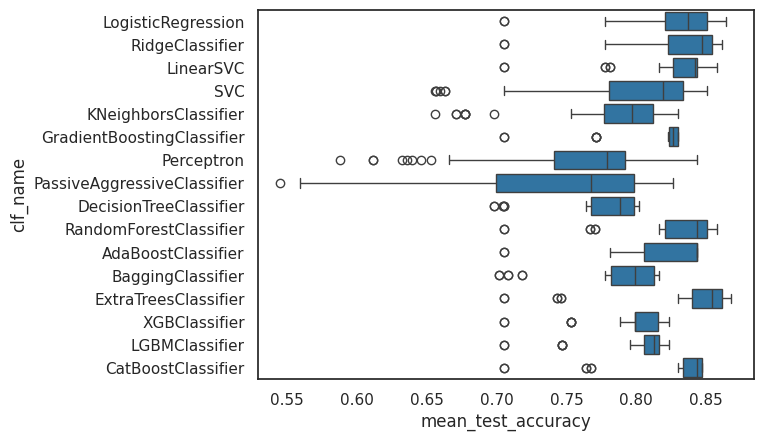

In [27]:
fig, ax = plt.subplots()
sns.boxplot(df_results, y="clf_name", x="mean_test_accuracy", ax=ax)
# ax.set_xlim(0.7, 1.0)
plt.show()

In [28]:
from sklearn.model_selection import cross_validate


best_model = deepcopy(grid_search.best_estimator_)
scores = cross_validate(best_model, X=df, y=df["output"].values, scoring="accuracy", cv=cv)["test_score"]
print(f"Mean CV Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.3f}")

Mean CV Accuracy: 0.8681 +/- 0.039


# Feature importances

## Permutation importance

Permutation importance is a *model agnostic* method to assess the impact of a feature on the predictive performance of a model. The process involves measuring the change in a 'scoring' function (e.g., accuracy, mean squared error) when the values of a specified feature are randomly shuffled, thereby breaking the relationship between that feature and the target variable. The model's performance is recalculated after shuffling, and the difference in the scoring metric before and after shuffling indicates the importance of the feature.

This process is typically repeated for `n_repeats` to account for variability, and the results can be visualized using a boxplot, where the spread (or variation) of the scores reflects the sensitivity of the model to changes in that feature. Refer to sklearn's documentation on for more details [Reference](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm).

Permutation importance <u>helps identify the most and least influential features in the model</u>. Features with low importance may be considered for exclusion, especially if they do not contribute significantly to the model's performance.

In [29]:
from sklearn.model_selection import train_test_split


# Training once more the model without cv
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=42,
                                     stratify=df["output"].values)
best_model.fit(df_train,
               df_train["output"].values);

In [30]:
feature_names = []
for name, transform in best_model.named_steps["features"].transformer_list:
    feature_names.extend(transform.get_feature_names_out())
feature_names = np.array(feature_names)
feature_names

array(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa',
       'chol_age_ratio', 'cp_thall', 'sex', 'fbs', 'exng', 'cp',
       'restecg', 'slp', 'thall', 'age_group', 'bp_category',
       'chol_range'], dtype='<U14')

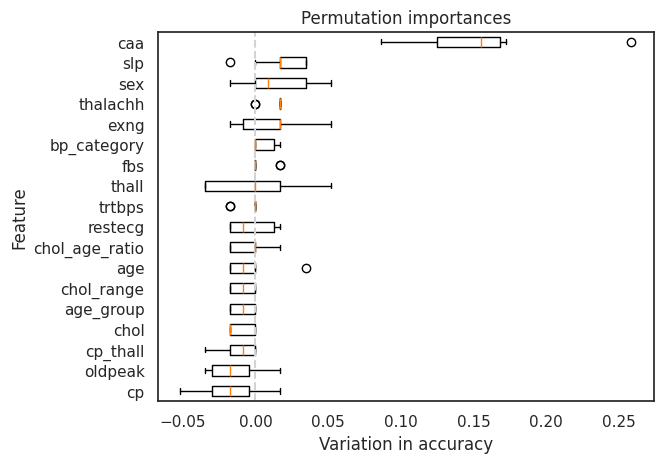

In [31]:
from sklearn.inspection import permutation_importance


# Calculating the model's importances
results = permutation_importance(best_model,
                                 df_test[feature_names], 
                                 df_test["output"],
                                 scoring="accuracy",
                                 n_repeats=10,
                                 random_state=42)
importances = results["importances"]
order = np.argsort(results["importances_mean"])

fig, ax = plt.subplots()
ax.boxplot(results.importances[order].T,
           tick_labels=feature_names[order],
           vert=False)
ax.set_title("Permutation importances")
ax.set_xlabel("Variation in accuracy")
ax.set_ylabel("Feature")
ax.vlines(0, *ax.get_ylim(), colors="lightgrey", linestyles="dashed")
plt.show()

Key outputs:
- Looks like none of the numerical features impact the model's predictions as seen by "age", "trtbps", "oldpeak", "thalachh" and "chol" being below the plot with little variation in the test's accuracy score (+/- 2%).
- The features "cp" and "caa" are the most influential in the model's performance with a <u>decrease</u> in the model's score up to 12.5%.

In [32]:
drop_features = feature_names[np.abs(results["importances_mean"]) <= 0.0].tolist()

numerical_features = [col for col in numerical_features if col not in drop_features]
nominal_features = [col for col in nominal_features if col not in drop_features]
ordinal_features = [col for col in ordinal_features if col not in drop_features]

In [33]:
drop_features

[]

In [34]:
# Altering the filtered columns
best_model.set_params(**{"features__numerical__columns": numerical_features,
                         "features__categorical-nominal__columns": nominal_features,
                         "features__categorical-ordinal__columns": ordinal_features})
# Evaluating
scores = cross_validate(best_model, X=df, y=df["output"].values, scoring="accuracy", cv=cv)["test_score"]
print(f"Mean CV Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.3f}")

Mean CV Accuracy: 0.8681 +/- 0.039


# Hyperparameter optimization

In [35]:
from typing import Dict, Callable, Any
import optuna


# Setting logging to activate only for warnings or worse
optuna.logging.set_verbosity(optuna.logging.WARNING)

def logreg_hp_search_space(trial: optuna.Trial) -> Dict:
    """
    Hyperparameters sampling for logistic regression.
    """
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None])
    if penalty == "l1":
        solver = trial.suggest_categorical("solver_l1", ["liblinear", "saga"])
    elif penalty == "l2":
        solver = trial.suggest_categorical("solver_l2", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"])
    elif penalty == "elasticnet":
        solver = "saga"
    else:
        solver = solver = trial.suggest_categorical("solver_none", ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"])

    params = {
        "penalty": penalty,
        "solver": solver,
        "C": trial.suggest_float("C", 1e-4, 1e2, log=True),
        "tol": trial.suggest_float("tol", 1e-6, 1e-4, log=True),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        "l1_ratio": trial.suggest_float("l1_ratio", 0., 1.) if penalty == "elasticnet" else None,
        "max_iter": 1000,
        "random_state": 42
    }
    return params


def extratrees_hp_search_space(trial: optuna.Trial) -> Dict:
    """
    Hyperparameters sampling for Extra Trees classifier.
    """
    params = {
        "n_estimators": 200,
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 2, 32, log=True),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
        "random_state": 42
    }
    return params

In [36]:
def objective(trial: optuna.Trial,
              return_model: bool=False) -> float:
    """
    """
    # Selecting the hyperparameters
    params = extratrees_hp_search_space(trial)
    # Adjusting the model's params
    best_model.named_steps["clf"].set_params(**params)
    if return_model:
        return best_model
    # Cross validator
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    # Run cross validation
    scores = cross_validate(best_model, 
                            X=df,
                            y=df["output"].values,
                            scoring="accuracy",
                            cv=cv)["test_score"]
    return np.mean(scores)

In [37]:
%%time
from tqdm.auto import tqdm


# Creating a new study
study = optuna.create_study(direction="maximize")
# Running the study
n_trials = 200
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    study.optimize(objective, 
                   n_trials=n_trials,
                   callbacks=[lambda study, trial: pbar.update(1), 
                              lambda study, trial: pbar.set_description(f"Best Trial: {study.best_trial.number} - Score: {study.best_trial.value:.4f}")])

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2min 26s, sys: 237 ms, total: 2min 26s
Wall time: 2min 26s


In [38]:
best_trial = study.best_trial
print(f"Best Trial: {best_trial.number} - Accuracy: {best_trial.value:.4f}")
best_params = best_trial.params
best_params

Best Trial: 138 - Accuracy: 0.8785


{'criterion': 'entropy',
 'max_depth': 32,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': False,
 'class_weight': None}

# Final model

## Performance

In [39]:
%%time
# Best model
best_model = objective(best_trial, return_model=True)
# Cross validation
scores = cross_validate(best_model,
                        X=df,
                        y=df["output"].values,
                        scoring="accuracy", 
                        cv=cv)["test_score"]
print(f"Mean CV Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.3f}")

Mean CV Accuracy: 0.8785 +/- 0.042
CPU times: user 629 ms, sys: 10.9 ms, total: 640 ms
Wall time: 639 ms


## Model weights

In [40]:
%%time
best_model.fit(X=df, y=df["output"].values)

CPU times: user 124 ms, sys: 9.93 ms, total: 134 ms
Wall time: 133 ms


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numerical',
                                                 PreprocessPipeline(columns=['age',
                                                                             'trtbps',
                                                                             'chol',
                                                                             'thalachh',
                                                                             'oldpeak',
                                                                             'caa',
                                                                             'chol_age_ratio',
                                                                             'cp_thall'])),
                                                ('categorical-nominal',
                                                 PreprocessPipeline(columns=['sex',
                                                                             'fbs',
                                                                             'exng'],
                                                                    transformer=TargetEncoder(random_state=42))),
                                                ('categorical-ordinal',
                                                 PreprocessPipeline(columns=['cp',
                                                                             'restecg',
                                                                             'slp',
                                                                             'thall',
                                                                             'age_group',
                                                                             'bp_category',
                                                                             'chol_range']))])),
                ('clf',
                 ExtraTreesClassifier(criterion='entropy', max_depth=32,
                                      min_samples_split=5, n_estimators=200,
                                      random_state=42))])

In [41]:
import pickle
from datetime import datetime


model_path = f"model-weights_{datetime.today().strftime('%Y%m%d')}.pkl"
with open(model_path, "wb") as pkl_file:
    pickle.dump(best_model, pkl_file)

print(f"Best model stored at: {model_path}")

Best model stored at: model-weights_20240908.pkl


# Explaining the final model

## Partial Dependency Plot

Partial dependency plots (PDPs) are used to explain <u>how a feature affects the model's predictions on average</u>. Unlike permutation importance, which assesses the impact of a feature on the model's overall performance, PDPs illustrate the relationship between a specific feature and the model's predictions by showing how the predictions change as the feature's values vary, while all other features are held constant.

The process to create a partial dependency plot involves the following steps:
- Select a feature and determine its minimum and maximum values.
- Generate a range of values within the minimum and maximum limits of the selected feature.
- For each value in this range, replace the corresponding feature values of all instances in the dataset with the current value.
- Use the model to generate predictions for these modified instances and calculate the mean prediction (expected value) for each feature value.

This process results in an array with a range of values for the selected feature (X-axis) and the corresponding average predictions of the model, denoted as $(E[f(x)])$, for each feature value (Y-axis).

In [42]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Callable, Optional, Iterable


def plot_pdp(feature_name: str,
             predict_func: Callable,
             data: pd.DataFrame,
             npoints: int=150) -> None:
    """
    Plots a Partial Dependence Plot (PDP) for the feature at the given index.
    """
    min_, max_ = data[feature_name].min(), data[feature_name].max()
    # Generating synthetic values for the feature given the range
    std = np.std(data[feature_name])
    # Adding 1 std each side to broaden the feature range
    feature_values = np.linspace(min_ - std, max_ + std, num=npoints)
    # Getting the model's predictions and computing the average of
    # predictions for each value of the selected feature
    mean_predictions = []
    copy_data = data.copy()
    for val in feature_values:
        # Swapping the feature values on all instances by
        # the generated value
        copy_data[feature_name] = val
        # Calculate the model's outputs
        model_predictions = predict_func(copy_data)
        # Calculate the mean and store
        mean_predictions.append(model_predictions.mean())

    # Calculating the model expected value
    expected_value = np.mean(mean_predictions)
    feature_expected_value = np.mean(feature_values)

    # PLotting
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # pdp
    pdp = go.Scatter(x=feature_values, 
                     y=mean_predictions, 
                     name="Model Expected Value", 
                     hovertemplate=
                     "Mean Preds.: %{y:.2f}<br>" + 
                     f"{feature_name}" + ": %{x:,.2f}")
    fig.add_trace(pdp)
    fig.update_yaxes(range=[min(mean_predictions),
                            max(mean_predictions)],
                     secondary_y=False)
    # Histogram with actual data
    hist = go.Histogram(x=data[feature_name],
                        name=feature_name,
                        histnorm="probability",
                        opacity=0.6,
                        hovertemplate=
                        f"{feature_name}: " + "%{x:,.2f}<br>" +
                        "Prob.: %{y:.3f}")
    fig.add_trace(hist, secondary_y=True)
    # Adjust secondary yaxis
    fig.update_yaxes(range=[0, 1.0], 
                     secondary_y=True,
                     showticklabels=False) # Hide yaxis
    
    # Adding the mean expected value and feature expected value
    fig.add_hline(y=expected_value,
                  line_width=1,
                  line_dash="dash",
                  annotation_text="E[f(x)]", 
                  annotation_position="top right")
    fig.add_vline(x=feature_expected_value,
                  line_width=1,
                  line_dash="dash",
                  annotation_text=f"E[{feature_name}]",
                  annotation_position="top right")
    
    # Change figure size
    fig.update_layout(title="Partial Dependence Plot",
                      height=600,
                      width=800, 
                      plot_bgcolor="white")
    fig.update_yaxes(title=f"E[f(x)|{feature_name}]",
                     secondary_y=False)
    fig.update_xaxes(title=feature_name)
    fig.show()
    
        
plot_pdp("chol", 
         best_model.predict,
         df[feature_names]) # Selecting only input features which are actually used by the model

### Plot using shap package

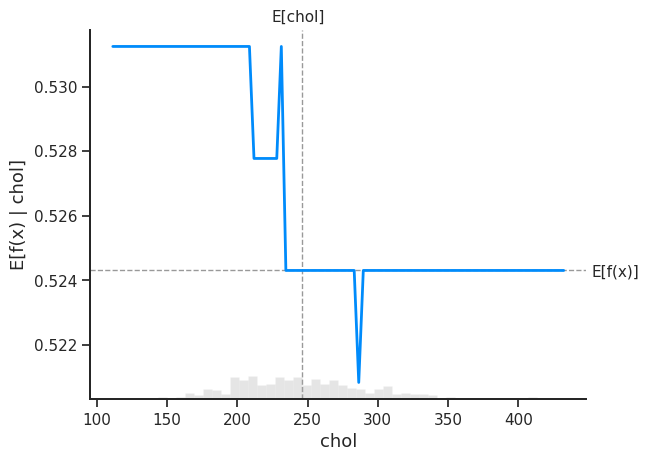

In [43]:
import shap


shap.partial_dependence_plot(
    "chol",
    best_model.predict,
    df[feature_names],
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## SHAP Values

SHAP (SHapley Additive exPlanations) values provide a way to interpret the output of a machine learning model by assigning each feature an importance value for a particular prediction. Unlike permutation importance, which evaluates the effect of shuffling a feature on model performance, and partial dependency plots, which show the average effect of a feature across all instances, SHAP values explain how much each feature contributes to a single prediction.

SHAP values are based on cooperative game theory and provide a fair allocation of feature contributions by considering all possible combinations of features. This method gives insights into which features are driving the predictions and whether their impact is positive or negative.

Comparison:
- **Permutation Importance**: Measures how much the model's performance changes when a feature is shuffled, giving a global sense of feature importance.
- **Partial Dependency Plots**: Show how the model's predictions change as the value of one feature varies, averaged across all instances.
- **SHAP Values**: Offer a detailed explanation for each prediction by quantifying the contribution of each feature, making it a powerful tool for understanding individual predictions.

In [44]:
%%time
explainer = shap.Explainer(best_model.predict,
                           df[feature_names],
                           feature_names=feature_names)

shap_values = explainer(df[feature_names])
shap_values.shape

PermutationExplainer explainer: 289it [01:34,  2.79it/s]                                                           

CPU times: user 1min 34s, sys: 386 ms, total: 1min 34s
Wall time: 1min 34s


(288, 18)

In [45]:
import plotly.express as px


def plot_summary_plot(shap_values: shap.Explainer,
                      feature_names: Iterable[str], 
                      index: Optional[pd.Index]=None):
    """
    Plots a summary plot which displays each data
    point individual feature contribution to the
    predicted output and if the feature value is
    high or low.
    """
    n_instances = len(shap_values.values)
    # From least to most influential feature
    order = np.abs(shap_values.values).mean(axis=0).argsort()
    ordered_feature_names = feature_names[order]
    
    # Manipulating the SHAP results to recreate a plot data
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names, index=index)
    # Stacking the columns into a sigle column
    shap_df = shap_df.stack().to_frame("shap_value")
    shap_df.index.rename(["id", "feature"], inplace=True)
    # Actual feature values
    data_df = pd.DataFrame(shap_values.data, columns=feature_names, index=index).stack().to_frame("feature_value")
    data_df.index.rename(["id", "feature"], inplace=True)
    # Joining the data
    shap_df = pd.merge(left=shap_df, 
                       right=data_df,
                       left_index=True,
                       right_index=True,
                       how="inner",
                       validate="one_to_one").reset_index(drop=False)
    
    # Finding if a feature value is high or low
    # In order to assess different scaled features I'll min max it
    # so every feature is in the range 0 to 1
    minmax_df = data_df.groupby("feature").agg(feature_min=("feature_value", "min"),
                                               feature_max=("feature_value", "max")).reset_index()
    shap_df = pd.merge(left=shap_df, 
                       right=minmax_df,
                       left_on="feature",
                       right_on="feature",
                       how="inner",
                       validate="many_to_one")
    # Normalizing
    shap_df["feature_value_norm"] = np.round((shap_df["feature_value"] - shap_df["feature_min"]) / (shap_df["feature_max"] - shap_df["feature_min"]), 1)

    # The actual plot
    fig = make_subplots()
    # Loop through each feature
    for i, feature in enumerate(ordered_feature_names, start=1):
        marker = dict(
            color=shap_df.loc[shap_df["feature"] == feature, "feature_value_norm"],
            colorscale="BlueRed",
            showscale=True if i == 1 else False,
            colorbar={
                "title": "Feature Value",
                "tickvals": [0.0, 1.0], 
                "ticktext": ["Low", "High"]}
        )
        trace = go.Scatter(x=shap_df.loc[shap_df["feature"] == feature, "shap_value"],
                           # Just positioning the feature and 
                           # adding "noise" to unstack the datapoints
                           # simulating a 'strip' plot
                           y=i + np.random.randn(n_instances) * 0.15,
                           name="",
                           mode="markers",
                           marker=marker,
                           customdata=shap_df.loc[shap_df["feature"] == feature, ["id", "feature_value"]],
                           hovertemplate=
                           "ID: %{customdata[0]}<br>" +
                           f"{feature}: " + "%{customdata[1]}<br>" + 
                           "SHAP: %{x:.3f}")
        fig.add_trace(trace)
        
    fig.update_xaxes(title="SHAP Value (impact on model prediction)")
    # Adding yaxis feature names
    fig.update_yaxes(tickvals=np.linspace(1., len(ordered_feature_names), num=len(ordered_feature_names)),
                     ticktext=ordered_feature_names)
    # Adding title and reshaping the plot
    fig.update_layout(title="Features contributions",
                      height=700,
                      width=800,
                      showlegend=False, 
                      plot_bgcolor="white")
    fig.add_vline(x=0, line_width=1)
    fig.show()


plot_summary_plot(shap_values,
                  feature_names, 
                  index=df.index)

### Built-in summary plot

The drawback is that you can't display custom data like the actual feature value for each datapoint.

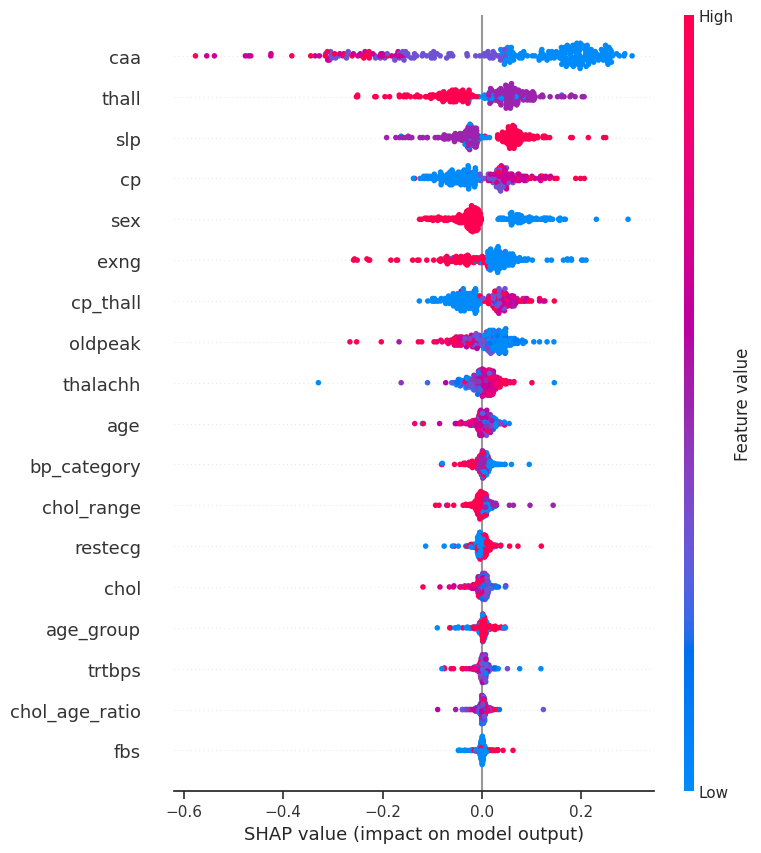

In [46]:
shap.summary_plot(shap_values, 
                  feature_names=feature_names)

## Explaining the predictions for an instance 

In [47]:
%%time
instance = df.sample(1, random_state=42)
shap_instance = explainer(instance[feature_names])
shap_instance

CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.68 s


.values =
array([[ 0.01307692,  0.00692308,  0.00538462,  0.01615385,  0.04038462,
         0.20461538,  0.00846154,  0.06076923, -0.01115385,  0.00038462,
         0.02961538,  0.05384615,  0.00076923,  0.05961538,  0.07384615,
        -0.00692308,  0.00615385, -0.00192308]])

.base_values =
array([0.44])

.data =
array([[ 47.        , 138.        , 257.        , 156.        ,
          0.        ,   0.        ,   5.46808511,   4.        ,
          1.        ,   0.        ,   0.        ,   2.        ,
          0.        ,   2.        ,   2.        ,   1.        ,
          2.        ,   2.        ]])

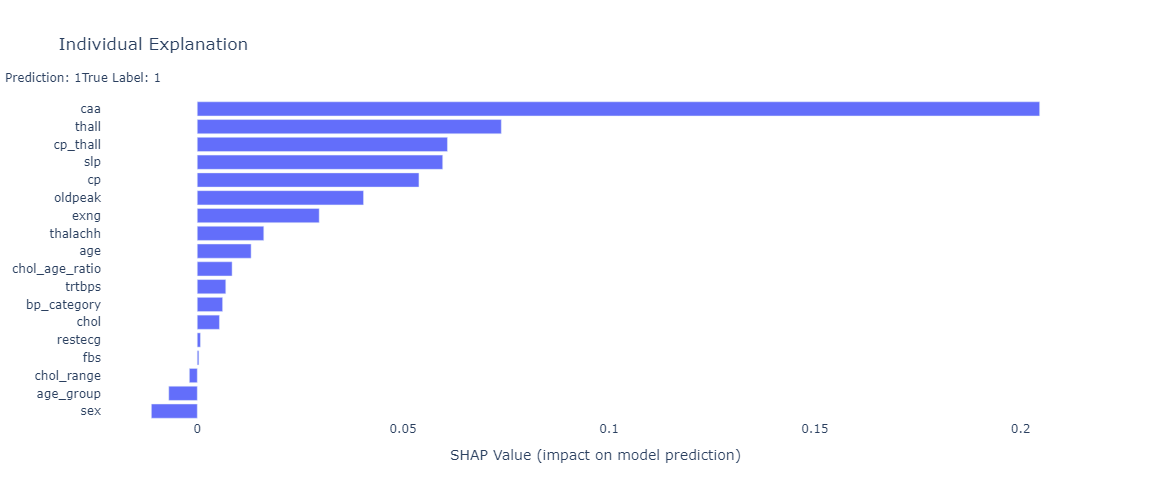

In [48]:
from typing import Any


def plot_individual_contribution(shap_values,
                                 feature_names: Any,
                                 predicted_label: Optional[str]=None,
                                 actual_label: Optional[str]=None):
    """
    """
    plot_data = pd.DataFrame({"shap_value": shap_values.values[0], 
                              "data": shap_values.data[0],
                              "feature": feature_names})
    plot_data.sort_values("shap_value", ascending=True, inplace=True)
    
    fig = make_subplots()
    
    fig.add_trace(go.Bar(
        x=plot_data["shap_value"],
        y=plot_data["feature"],
        orientation="h",
        customdata=plot_data["data"],
        hovertemplate="%{y}: %{customdata}<br>" + "SHAP: %{x:.3f}"
    ))
    fig.update_xaxes(title="SHAP Value (impact on model prediction)")
    # Adding title and reshaping the plot
    fig.update_layout(title="Individual Explanation",
                      height=500,
                      width=600,
                      showlegend=False,
                      plot_bgcolor="white")
    subtitle = ""
    subtitle += f"Prediction: {predicted_label}" if predicted_label is not None else ""
    subtitle += f"True Label: {actual_label}" if actual_label is not None else ""
    
    fig.add_annotation(
        x=-0.10, 
        y=1.1,
        xref="paper",
        yref="paper",
        showarrow=False,
        text=subtitle
    )
    fig.show()

actual_label = instance["output"].values[0]
predicted_label = str(best_model.predict(instance)[0])
plot_individual_contribution(shap_instance,
                             feature_names=feature_names,
                             predicted_label=predicted_label,
                             actual_label=actual_label)